# Sensitivity analysis of ODE solutions

This is an example application of the methods described in **chapter 9** of our [course notes on "Matrix Calculus" (MIT 18.063)](https://www.dropbox.com/scl/fi/iq4plt8oqja845cuuosa4/Matrix-Calculus-latest.pdf?rlkey=nsnytdu28jje41nhh1bl2dbba&st=i6lfha0r&dl=0), in which we find the derivative(s) of ODE *solutions* with respect to ODE *parameters*, even though the ODE itself must generally be **solved numerically** (so that we have no closed-form expression for the solution we are differentiating).

Here, we apply it to the famous dynamical system of a [double pendulum](https://en.wikipedia.org/wiki/Double_pendulum), which exhibits [chaos](https://en.wikipedia.org/wiki/Chaos_theory): the solutions have a sensitivity (to initial conditions, parameters, discretization approximations…) that *grows exponentially* with time.

In [1]:
using DifferentialEquations, Plots, ForwardDiff, StaticArrays, LaTeXStrings, LinearAlgebra

## Double Pendulum

![double pendulum](https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg)

Dynamics of a double pendulum, adapted from [this tutorial by Ryan C. Cooper (2024)](https://cooperrc.github.io/Julia-learning/day_06.html), for the dynamics $\dot{u} = f(u,t)$ of the state $u=[\theta_1,\theta_2,\dot{\theta}_1,\dot{\theta}_2]$, described  by the system of ODEs:

1. $L_1^2\left(m_1 + m_2\right)\ddot{\theta}_1 + m_2L_1L_2\cos\left(\theta_1 - \theta_2\right)\ddot{\theta}_2 +m_2L_1L_2\dot{\theta}_2^2\sin\left(\theta_1 - \theta_2) + gL_1(m_1 + m_2 \right)\sin\theta_1 = 0$

2. $m_2L_1L_2\cos\left(\theta_1 - \theta_2\right)\ddot{\theta}_1 + m_2L_2^2\ddot{\theta}_2 - m_2L_1L_2\dot{\theta}_1^2\sin\left(\theta_1-\theta_2\right) +m_2gL_2\sin\theta_2 = 0$

(Also derived by Prof. Drew Baden at [this UMD page](https://physics.umd.edu/hep/drew/pendulum2.html).)

Note that, at each step, we need to solve a $2 \times 2$ linear system of equations to determine $[\ddot{\theta}_1, \ddot{\theta}_2]$ from $[\theta_1,\theta_2,\dot{\theta}_1,\dot{\theta}_2]$.  I use the [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl) package in Julia, which allows us to deal extremely efficiently with small fixed-size vectors and matrices like the ones here (allowing the compiler to specialize all the code for the specific matrix and vector sizes here).  (It is also possible to solve for $\ddot{\theta}_1, \ddot{\theta}_2$ in closed-form, of course.)

Computationally, all we need to do is to implement the right-hand-side $f$ of $\dot{u} = f(u, p, t)$, where $p$ are some parameters:

In [2]:
function doublependulum(u, params, t)
    g = 9.80665 # Earth gravity (m/s²)
    (; l1, l2, m1, m2) = params

    Δθ = u[1] - u[2]
    M = @SMatrix[l1*(m1+m2)   m2*l2*cos(Δθ)
                 l1*cos(Δθ)   l2]
    rhs = @SVector[-m2*l2*u[4]^2*sin(Δθ) - g*(m1+m2)*sin(u[1]),
                   l1*u[3]^2*sin(Δθ) - g*sin(u[2])]
    θ̈ = M \ rhs
    u̇ = @SVector[u[3], u[4], θ̈[1], θ̈[2]]
    return u̇
end

doublependulum (generic function with 1 method)

Given this, we can hand our function $f$ (`doublependulum`) and an initial condition to a [numerical ODE solver](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations), tell it the desired range of times $t$ where we want the solution, and a desired accuracy, and it will do the rest.

Here, we use [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/), which is a world-class suite of ODE solvers implemented in Julia.

This system is **chaotic** , so even a tiny change in the initial conditions leads to an exponentially growing change int he solution:

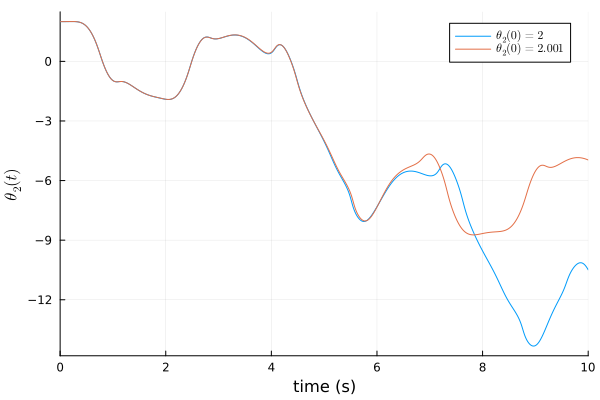

In [3]:
tspan = (0, 10);
p = (; l1=1, l2=1, m1=0.1, m2=0.1)

prob1 = ODEProblem(doublependulum, @SVector[2, 2.0, 0, 0], tspan, p)
sol1 = solve(prob1, reltol = 1e-10)
prob2 = ODEProblem(doublependulum, @SVector[2, 2.001, 0, 0], tspan, p)
sol2 = solve(prob2, reltol = 1e-10)

plot(sol1, idxs=2, label=L"\theta_2(0) = 2")
plot!(sol2, idxs=2, label=L"\theta_2(0) = 2.001")
plot!(xlabel="time (s)", ylabel=L"\theta_2(t)")

## Sensitivity to initial conditions (forward mode)

Let the initial conditions (IC) be $u(0)=b$.   If we want the Jacobian $J = \partial u / \partial b$ as a function of time, we show in the course notes that $J(t)$ satisfies:
$$
\frac{\partial J}{\partial t} = \frac{\partial f}{\partial u} J
$$
with initial condition $J(0) = \frac{\partial u(0)}{\partial b} = I$.   Note that this is a *linear* ODE, but the system matrix $\frac{\partial f}{\partial u}$ is time-varying so the answer is not merely a matrix exponential.

Since we are solving this forward-mode, we can evolve $(u, J)$ at the same time, concatenating them into a vector of $4 + 4^2 = 20$ entries: that is, we solve a *single* system of 20 coupled ODEs, corresponding to:
$$
\frac{\partial}{\partial t} \begin{bmatrix} u \\ J \end{bmatrix} = \begin{bmatrix} f \\ \frac{\partial f}{\partial u} J \end{bmatrix} = F(u,J,t)
$$
implemented as `doublependulum_∂IC` below:

In [4]:
function doublependulum_∂IC(uJ, params, t)
    # extract u and J from uJ
    u = SVector(ntuple(i -> uJ[i], Val(4)))
    J = reshape(SVector(ntuple(i -> uJ[i + 4], Val(16))), Size(4,4))

    u̇ = doublependulum(u, params, t)
    J̇ = ForwardDiff.jacobian(u -> doublependulum(u, params, t), u) * J
    return [u̇; vec(J̇)]
end

doublependulum_∂IC (generic function with 1 method)

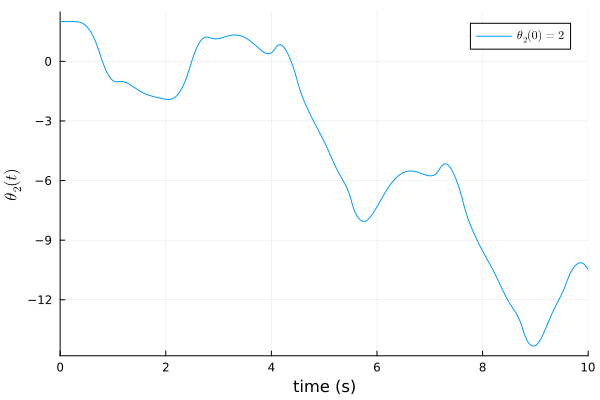

In [5]:
I₄ = @SMatrix[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1]

prob_diff = ODEProblem(doublependulum_∂IC, [@SVector[2, 2.0, 0, 0]; vec(I₄)], tspan, p)
sol_diff = solve(prob_diff, reltol = 1e-10)

plot(sol_diff, idxs=2, label=L"\theta_2(0) = 2")
plot!(xlabel="time (s)", ylabel=L"\theta_2(t)")

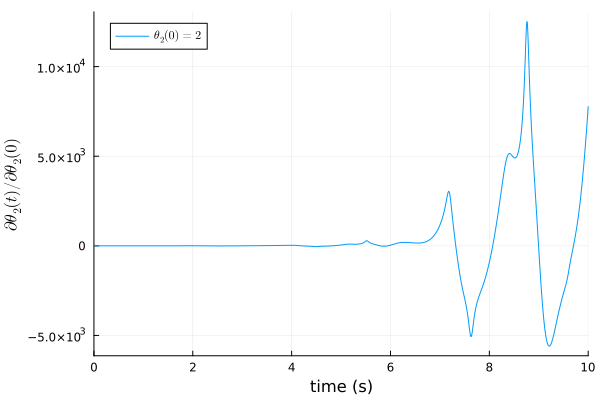

In [6]:
plot(sol_diff, idxs=10, label=L"\theta_2(0) = 2")
plot!(xlabel="time (s)", ylabel=L"\partial\theta_2(t)/\partial\theta_2(0)")

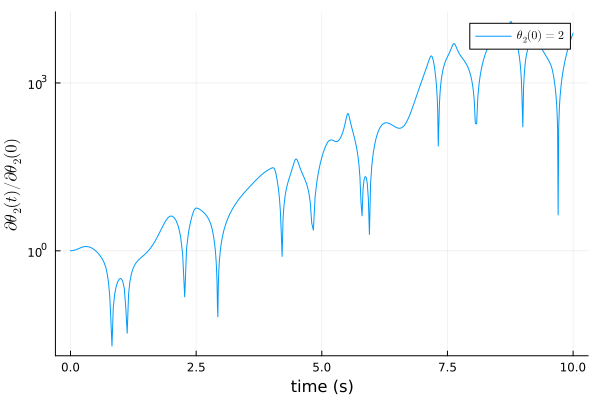

In [7]:
plot(sol_diff.t, abs.(sol_diff[10,:]), label=L"\theta_2(0) = 2", yaxis=:log)
plot!(xlabel="time (s)", ylabel=L"\partial\theta_2(t)/\partial\theta_2(0)")

### Finite-difference check:

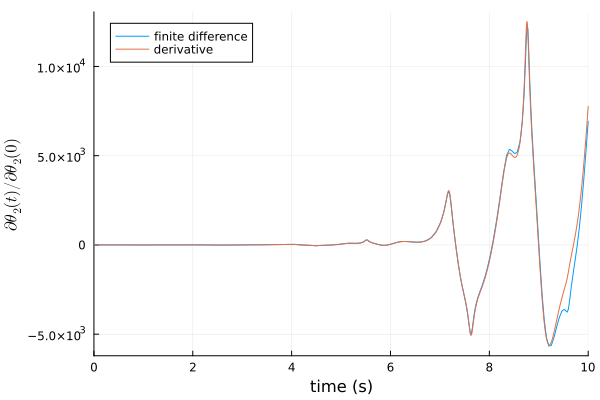

In [8]:
prob1_delta = ODEProblem(doublependulum, @SVector[2, 2 + 1e-5, 0, 0], tspan, p)
sol1_delta = solve(prob1_delta, reltol = 1e-10)

dθ₂ = sol1_delta(sol1.t)[2,:] - sol1[2,:]
plot(sol1.t, dθ₂ / 1e-5, label="finite difference")
plot!(sol_diff, idxs=10, label="derivative")
plot!(xlabel="time (s)", ylabel=L"\partial\theta_2(t)/\partial\theta_2(0)")

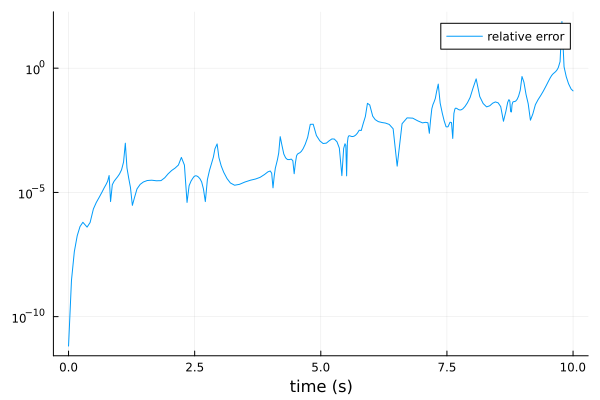

In [9]:
plot(sol1.t, abs.(dθ₂ - 1e-5 * sol_diff(sol1.t)[10,:]) ./ abs.(dθ₂),
    label="relative error", yaxis=:log, xlabel="time (s)")

Hooray, the finite-difference check matches to about five digits, although the difference grows with time thanks to the chaotic nature of this problem.

(Five digits is about all we can hope for here, thanks to a combination of the truncatio error from using a $\delta \theta_2(0) = 10^{-5}$ and the fact that we "only" requested the solution to 10 digits.)

## Reverse-mode (“adjoint”) sensitivity analysis

The general weakness of forward-mode differentiation is that, if we have $N$ parameters, the cost is roughly $N \times$ the cost of a single forward solve.  (In the example above, we have to solve an ODE with 20 variables instead of 4.)

*If* we are computing only a *scalar* function $G$ of $u(t)$, then we can (in principle) do *much* better: we only need to integrate a *single* additional “adjoint” ODE of the *same size* as the original ODE, and get all the derivatives $\nabla G$, regardless of the number of parameters.  This is an instance of “reverse-mode” differentiation, also known as an “adjoint” method or “backpropagation”, and is described in detail by chapter 9 of our course notes (linked above).

In the course notes, we supposed we had a scalar function $G(p) = \int_0^T g(u(p,t), p, t) \, dt$, for some integrand $g(u,p,t)$, and showed that we could compute the gradient by:
$$
\nabla_p G = -\left(\frac{\partial u(p,0)}{\partial p}\right)^T v(0) + \int_0^T \left[ \left(\frac{\partial g}{\partial p}\right)^T - \left(\frac{\partial f}{\partial p}\right)^T v \right] dt
$$
where $v(t)$ (of the same size as $u$) satisfies the “adjoint” differential equation
$$
\frac{\partial v}{\partial t} = \left(\frac{\partial g}{\partial u}\right)^T - \left(\frac{\partial f}{\partial u}\right)^T v
$$
with *final* condition $v(T) = 0$ (i.e. we integrate $v$ *backward* in time).  (It is an “adjoint” equation because of the *transpose*.)

Importantly, note that the adjoint equation **depends on u** (through $g$ and $f$), so we need to **save** the “forward” solution $u(p,t)$ in order to solve the adjoint equations.  Fortunately, DifferentialEquations.jl gives us this: a solution object like `sol1` above can be treated as a function `sol1(t)`, which internally interpolates $u(t)$ at any time $t$ with a high-order polynomial (the same order used to solve the ODE).

### Example

Let's do a specific example.  Suppose that our parameters are simply our initial condition $u(p,0) = p$ as in the forward-mode example, and suppose that our $G(p)$ is simply given by $\Vert u(p,t_0) \Vert^2$ for a single time $0 < t_0 < T$.  This corresponds to
$$
g(u, p, t) = \Vert u \Vert^2 \delta(t - t_0)
$$
in terms of a Dirac delta function.

What then happens to our equations above?

1. Neither $g$ nor $f$ depend explicitly on $p$ (the initial conditions), so $\nabla_p G$ simplifies to
$$
\nabla_p G = -\left(\frac{\partial u(p,0)}{\partial p}\right)^T v(0) = \boxed{-v(0)} \, ,
$$
since $\frac{\partial u(p,0)}{\partial p} = \frac{\partial p}{\partial p} = I$.

2. At all times $t \ne t_0$, we have $g = 0$ so the adjoint equation for $v$ simplifies to $$\boxed{\frac{\partial v}{\partial t} = - \left(\frac{\partial f}{\partial u}\right)^T v} \, ,$$
whose solution is $v = 0$ for $t > t_0$.

3. $\left(\frac{\partial g}{\partial u}\right)^T = \nabla_p g = 2 u(p, t_0) \delta(t - t_0)$ causes $v(t) = \nabla_u g - \cdots$ to have a discontinuity $2 u(p, t_0)$ at $t = t_0$: we already know $v(t_0^+) = 0$, so that means $\boxed{v(t_0^-) = -2 u(p, t_0)}$.

The combination of (2) and (3) means we can start the adjoint equation at $t = t_0$ with $v(t_0) = -2 u(p, t_0)$.

Let's implement it, letting $t_0 = 2$:

In [10]:
function doublependulum_adjoint(v, params, t)
    (; u, p) = params
    
    # again, we'll use AD to compute ∂f/∂u
    v̇ = -ForwardDiff.jacobian(u -> doublependulum(u, p, t), u(t))' * v
    return v̇
end

doublependulum_adjoint (generic function with 1 method)

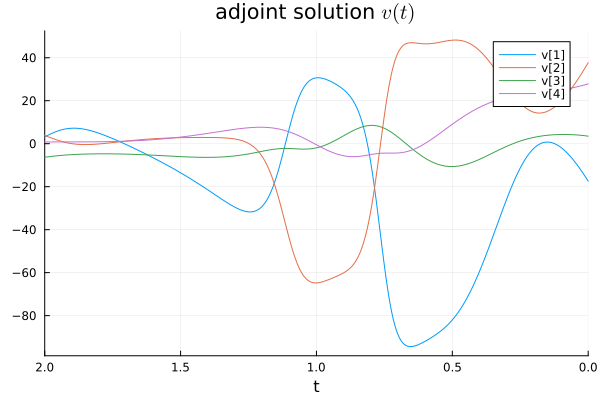

In [11]:
t₀ = 2
v₀ = -2sol1(t₀)

prob_adjoint = ODEProblem(doublependulum_adjoint, v₀, (t₀, 0), (; u=sol1, p=p))
v = solve(prob_adjoint, reltol = 1e-10)

plot(v, title=L"adjoint solution $v(t)$", label=["v[1]" "v[2]" "v[3]" "v[4]"])

Note that the time axis is “backwards” because we started at $t=t_0=2$ and integrated to $t=0$.

This predicts our gradient should be $-v(0)$:

In [12]:
-v(0)

4-element SVector{4, Float64} with indices SOneTo(4):
  17.425299831388337
 -37.713013164436575
  -3.517135042260177
 -27.855982336366683

Let's compare this to our forward-mode answer:
$$
dG = 2u^T du = \underbrace{2u^T \frac{\partial u}{\partial p}}_{(\nabla_p G)^T} dp \Longleftrightarrow \nabla_p G = \left( \frac{\partial u}{\partial p} \right)^T 2u = 2 J(t_0)^T u(t_0)
$$

In [13]:
uJ₀ = sol_diff(t₀)
J₀ = reshape(SVector(ntuple(i -> uJ₀[i + 4], Val(16))), Size(4,4))
J₀' * 2sol1(t₀)

4-element SVector{4, Float64} with indices SOneTo(4):
  17.425310160434826
 -37.7130498818074
  -3.517137064485507
 -27.856006327870688

Hooray, they match!

They match to about 6 digits, limited by the `reltol=1e-10` of our ODE solution and the chaotic sensitivity of this system to tiny perturbations:

In [14]:
norm(J₀' * 2sol1(t₀) + v(0)) / norm(v(0))

8.995586394425807e-7